# Convolutional Neural Network (CNN)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/02_cnn/cnn.ipynb)
- Unofficial notebook (pytorch): [Github](https://github.com/terrence-ou/Generative-Deep-Learning-2nd-Edition-PyTorch-JAX/blob/main/PyTorch/chapter_02_deeplearning/02_CNN.ipynb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import v2

from torchinfo import summary
from torchmetrics.classification import Accuracy

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## 0. Parameters

In [ ]:
NUM_CLASSES = 10

## 1. Prepare the Data

### Dataset

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor(),
])

In [ ]:
dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

n_val = int(len(dataset_test)*0.2)
n_test = len(dataset_test) - n_val

dataset_test, dataset_val = torch.utils.data.random_split(dataset_test, [n_test, n_val],
                                                          generator=torch.Generator().manual_seed(SEED))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f"Train: {len(dataset_train)}")
print(f"Val: {len(dataset_val)}")
print(f"Test: {len(dataset_test)}")

Train: 50000
Val: 2000
Test: 8000


In [ ]:
id2cls = {i: cls for i, cls in enumerate(dataset_train.classes)}
id2cls

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
dataset_val[0][0].shape, dataset_val[0][1]

(torch.Size([3, 32, 32]), 1)

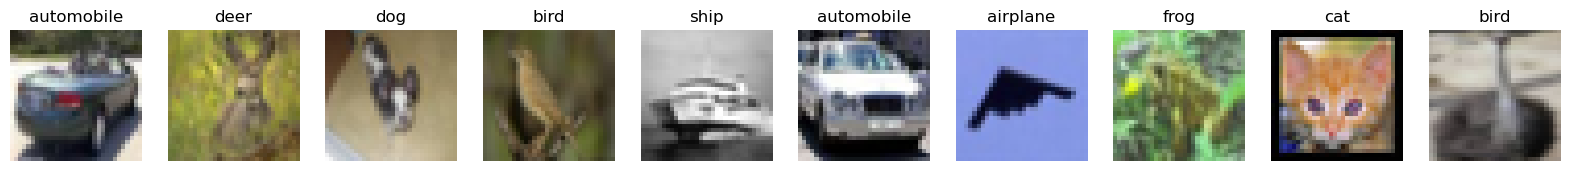

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(dataset_val[i][0].permute(1, 2, 0))
    plt.title(id2cls[dataset_val[i][1]])
    plt.axis("off")

plt.show()

### DataLoader

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
batch = next(iter(dataloader_val))
images, labels = batch
images.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

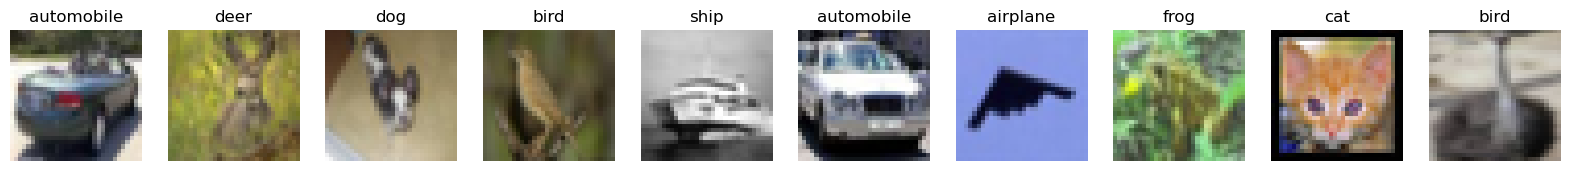

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(id2cls[labels[i].item()])
    plt.axis("off")

plt.show()

## 2. Build the model

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layers = nn.Sequential(
            nn.LazyConv2d(out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),

            nn.LazyConv2d(out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),

            nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),

            nn.LazyConv2d(out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),

            nn.Flatten(),

            nn.LazyLinear(128),
            nn.LazyBatchNorm1d(),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.LazyLinear(num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("medium")

In [ ]:
model = CNN(num_classes=NUM_CLASSES)
model = model.to(device)
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─LeakyReLU: 2-3                    [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 16, 16]           64
│    └─LeakyReLU: 2-6                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 16, 16]           128
│    └─LeakyReLU: 2-9                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-10                      [1, 64, 8, 8]             36,928
│    └─BatchNorm2d: 2-11                 [1, 64, 8, 8]             128
│

## 3. Train the model

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

accuracy_train = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy_train = accuracy_train.to(device)

accuracy_val = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy_val = accuracy_val.to(device)

In [ ]:
metrics = {
    "train": {"loss": [], "accuracy": []},
    "val": {"loss": [], "accuracy": []},
}

results_dir = Path("results")
results_dir.mkdir(exist_ok=True, parents=True)

best_accuracy = 0

n_epochs = 10

for epoch in range(n_epochs):
    # Training
    model.train()

    loss_train = 0

    tqdm_train = tqdm(dataloader_train)
    tqdm_train.set_description("Epoch {:02d}/{:2d} (Train)".format(epoch+1, n_epochs))
    for batch in tqdm_train:
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        acc = accuracy_train(outputs, labels)
        loss_train += loss.item()

        tqdm_train.set_postfix_str("loss {:.4f}, accuracy {:.4f}".format(loss.item(), acc.item()))


    loss_train = loss_train / len(dataloader_train)
    acc_train = accuracy_train.compute()
    accuracy_train.reset()

    print("(Train) loss {:.4f}, accuracy {:.4f}".format(loss_train, acc_train))
    metrics["train"]["loss"].append(loss_train)
    metrics["train"]["accuracy"].append(acc_train.item())

    torch.save(model.state_dict(), results_dir/"last.pth")

    # Validation
    model.eval()

    loss_val = 0
    
    tqdm_val = tqdm(dataloader_val)
    tqdm_val.set_description("Epoch {:02d}/{:2d} (Val)  ".format(epoch+1, n_epochs))
    for batch in tqdm_val:
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

            accuracy_val(outputs, labels)
            loss_val += loss.item()

    loss_val = loss_val / len(dataloader_val)
    acc_val = accuracy_val.compute()
    accuracy_val.reset()

    print("(Val)   loss {:.4f}, accuracy {:.4f}".format(loss_val, acc_val))
    metrics["val"]["loss"].append(loss_val)
    metrics["val"]["accuracy"].append(acc_val.item())

    if acc_val > best_accuracy:
        best_accuracy = acc_val
        torch.save(model.state_dict(), results_dir/"best.pth")

Epoch 01/10 (Train): 100%|██████████| 1563/1563 [00:15<00:00, 103.09it/s, loss 1.1150, accuracy 0.6250]


(Train) loss 1.3561, accuracy 0.5197


Epoch 01/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 167.49it/s]


(Val)   loss 1.0112, accuracy 0.6395


Epoch 02/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 109.99it/s, loss 1.2328, accuracy 0.5625]


(Train) loss 0.9911, accuracy 0.6560


Epoch 02/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 185.39it/s]


(Val)   loss 0.8416, accuracy 0.7115


Epoch 03/10 (Train): 100%|██████████| 1563/1563 [00:13<00:00, 113.16it/s, loss 0.8197, accuracy 0.7500]


(Train) loss 0.8520, accuracy 0.7033


Epoch 03/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 186.12it/s]


(Val)   loss 0.8086, accuracy 0.7055


Epoch 04/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 110.60it/s, loss 0.3576, accuracy 0.9375]


(Train) loss 0.7531, accuracy 0.7383


Epoch 04/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 172.87it/s]


(Val)   loss 0.7534, accuracy 0.7275


Epoch 05/10 (Train): 100%|██████████| 1563/1563 [00:13<00:00, 113.04it/s, loss 1.1801, accuracy 0.5625]


(Train) loss 0.6775, accuracy 0.7633


Epoch 05/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 178.28it/s]


(Val)   loss 0.7130, accuracy 0.7455


Epoch 06/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 109.70it/s, loss 0.6613, accuracy 0.6875]


(Train) loss 0.6144, accuracy 0.7861


Epoch 06/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 182.76it/s]


(Val)   loss 0.7082, accuracy 0.7525


Epoch 07/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 108.80it/s, loss 0.5474, accuracy 0.7500]


(Train) loss 0.5574, accuracy 0.8041


Epoch 07/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 180.70it/s]


(Val)   loss 0.7260, accuracy 0.7525


Epoch 08/10 (Train): 100%|██████████| 1563/1563 [00:13<00:00, 111.96it/s, loss 0.3477, accuracy 0.8750]


(Train) loss 0.5074, accuracy 0.8210


Epoch 08/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 172.49it/s]


(Val)   loss 0.7009, accuracy 0.7475


Epoch 09/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 109.78it/s, loss 0.2855, accuracy 0.8750]


(Train) loss 0.4627, accuracy 0.8377


Epoch 09/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 175.26it/s]


(Val)   loss 0.7108, accuracy 0.7540


Epoch 10/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 110.57it/s, loss 0.4637, accuracy 0.7500]


(Train) loss 0.4197, accuracy 0.8511


Epoch 10/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 179.16it/s]

(Val)   loss 0.7540, accuracy 0.7640


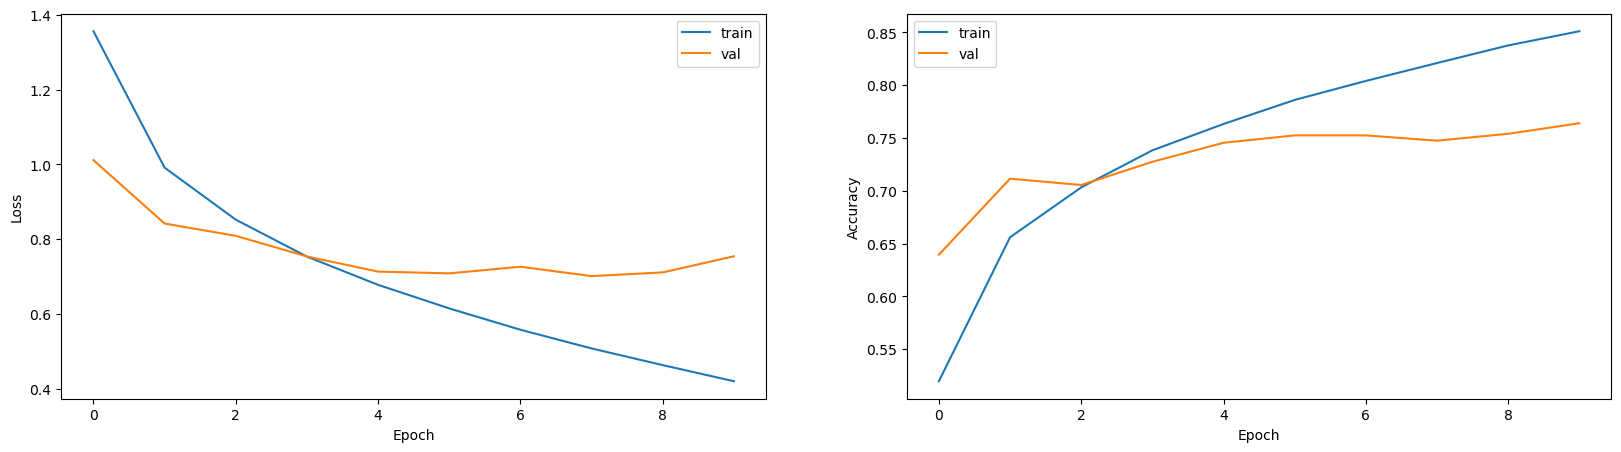

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
ax.plot(metrics["train"]["loss"], label="train")
ax.plot(metrics["val"]["loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

ax = axes[1]
ax.plot(metrics["train"]["accuracy"], label="train")
ax.plot(metrics["val"]["accuracy"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

plt.show()

## 4. Evaluation

In [ ]:
model = CNN(num_classes=NUM_CLASSES)
model = model.to(device)
model.load_state_dict(torch.load(results_dir/"best.pth", weights_only=True))
model.eval()

accuracy_test = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy_test = accuracy_test.to(device)

test_losses = []
test_preds = []
test_labels = []
for batch in tqdm(dataloader_test):
    images, labels = batch 
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
        outputs = model(images)
        loss = criterion(outputs, labels)

        accuracy_test(outputs, labels)
        test_losses.append(loss.item())

        pred_prob = torch.softmax(outputs, dim=1)
        pred_index = torch.argmax(pred_prob, dim=1)
        test_preds.append(pred_index.cpu().numpy())

        test_labels.append(labels.cpu().numpy())


test_loss = sum(test_losses) / len(test_losses)
test_acc = accuracy_test.compute()
accuracy_test.reset()
print("(Test)  loss {:.4f}, accuracy {:.4f}".format(test_loss, test_acc))

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

100%|██████████| 250/250 [00:01<00:00, 183.87it/s]

(Test)  loss 0.7612, accuracy 0.7540


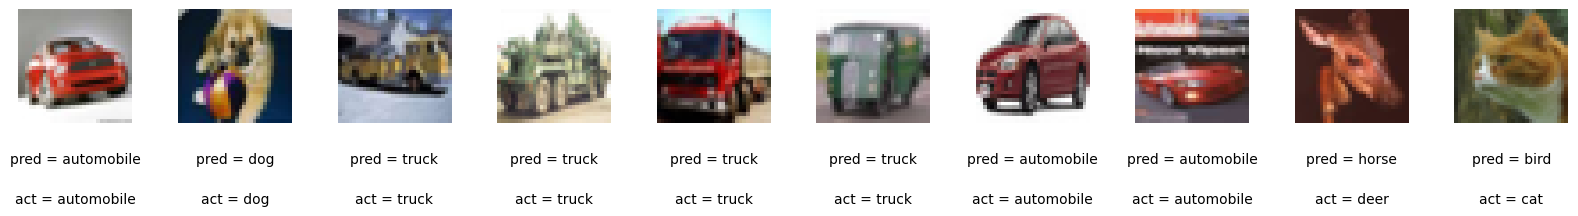

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(dataset_test)), n_to_show)

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = dataset_test[idx][0].permute(1, 2, 0)
    
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + id2cls[test_preds[idx]],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + id2cls[test_labels[idx]],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)